In [382]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re

In [383]:
import html
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/berra.dogan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [384]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [385]:
df = pd.read_csv(
    "dontpatronizeme_pcl.tsv",
    sep="\t",
    skiprows=9,
    engine="python",
    index_col=0,
    header=None,
    names = ["article_id", "keyword", "country", "text", "PCL_category"]
)

df["is_PCL"] = (df["PCL_category"] >= 2).astype(int)

df

,article_id,keyword,country,text,PCL_category,is_PCL
6,@@9382277,in-need,in,"To bring down high blood sugar levels , insuli...",0,0
7,@@7562079,refugee,za,The European Union is making an historic mista...,0,0
8,@@23663488,hopeless,nz,""" They 're either hopeless for being beaten by...",0,0
9,@@3449225,homeless,ph,"NUEVA ERA , Ilocos Norte - No family shall be ...",1,0
10,@@2485090,in-need,nz,His spokesman said the Kremlin needed more inf...,0,0
...,...,...,...,...,...,...
10465,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,1,0
10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10467,@@20282330,in-need,ng,""" She has one huge platform , and information ...",3,1
10468,@@16753236,hopeless,in,""" Anja Ringgren Loven I ca n't find a word to ...",4,1


In [386]:
print(f"{len(df[df.duplicated()])} duplicates are found")

0 duplicates are found


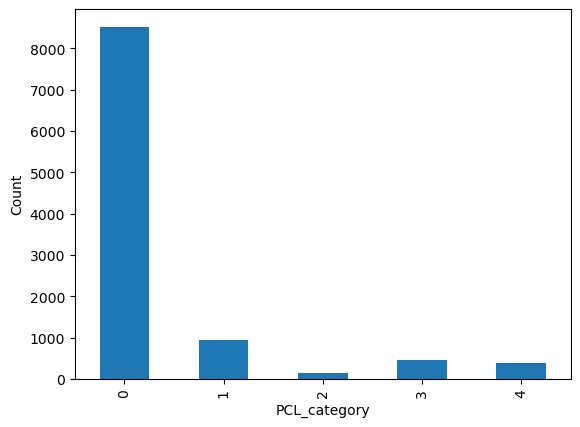

In [387]:
df["PCL_category"].value_counts().sort_index().plot(kind="bar")

plt.xlabel("PCL_category")
plt.ylabel("Count")
plt.show()


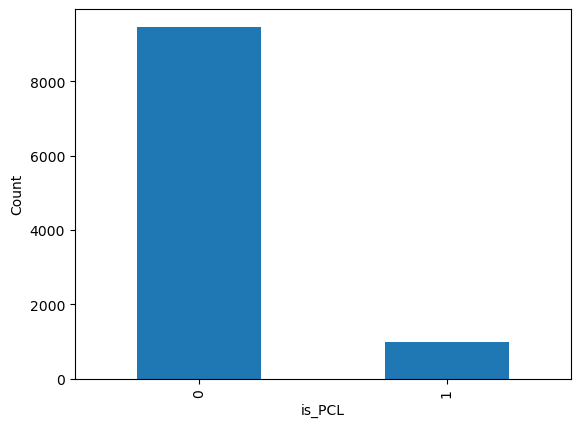

In [388]:
df["is_PCL"].value_counts().sort_index().plot(kind="bar")

plt.xlabel("is_PCL")
plt.ylabel("Count")
plt.show()


We can observe from the plots above that there is a class inbalance both for binary and categorical classification tasks. To handle this, we need to use sampling techniques or take advantage of class weighing properties of ML models.

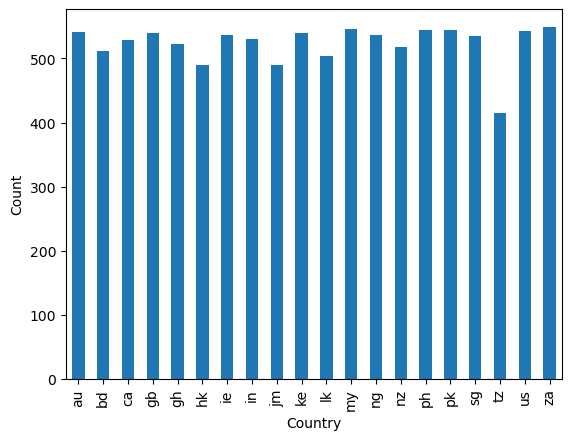

In [389]:
df["country"].value_counts().sort_index().plot(kind="bar")

plt.xlabel("Country")
plt.ylabel("Count")
plt.show()

<Axes: xlabel='keyword'>

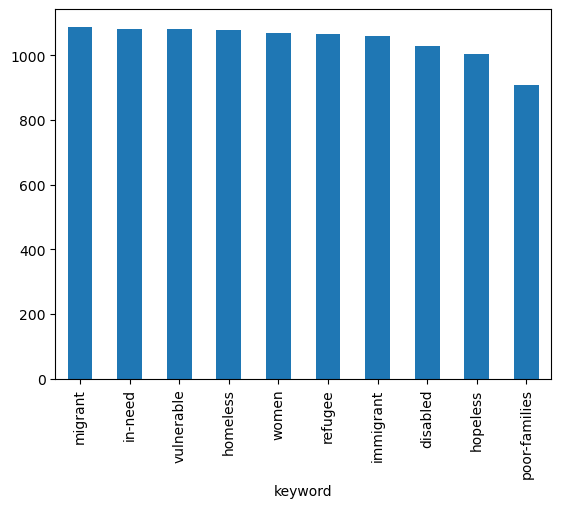

In [390]:
df["keyword"].value_counts().plot(kind="bar")

Number of datapoints per country and keyword are close for each division except Tanzania and "poor-families" (which is stillaround 20% lower than others). Rebalancing for countries or keywords does not seem neccessary.

In [391]:
df_engineered = df.copy()
df_engineered["sentence_len"] = df_engineered["text"].str.split().str.len()

In [392]:
df_engineered["sentence_len"].describe()

count    10463.000000
mean        48.424066
std         29.085247
min          1.000000
25%         30.000000
50%         42.000000
75%         60.000000
max        909.000000
Name: sentence_len, dtype: float64

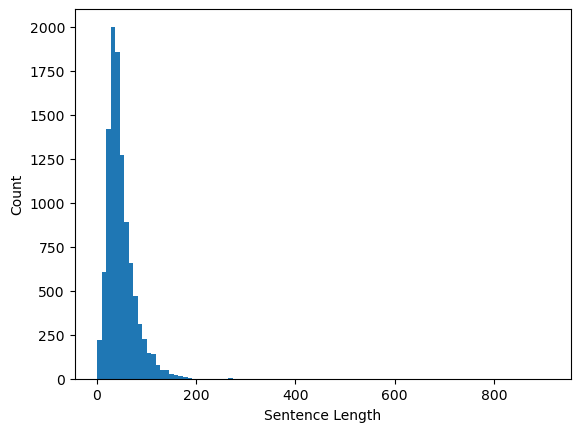

In [393]:
plt.hist(df_engineered["sentence_len"], bins=100)
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.show()

There seems to be some outliers in the dataset, that are too short (some with only a single word) or too long (x15 of 75% mark). The "too short" sentence may cause the model to overfit on the given words and take shortcuts instead of learning a meaningful pattern. On the other hand, "too long" will contribute disproportionately to the total loss and dominate gradients, causing overfitting. To avoid this unexpected behaviours, we can clean the outliers, by limiting minimum length to 3 and limiting the maximum distance to Q3 + 1.5 * IQR.

In [394]:
Q1 = df_engineered["sentence_len"].quantile(0.25)
Q3 = df_engineered["sentence_len"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = 3
upper_bound = Q3 + 1.5 * IQR

lower_bound, upper_bound

outliers = df_engineered[(df_engineered["sentence_len"] < lower_bound) | (df_engineered["sentence_len"]>upper_bound)]
outlier_percentage = len(outliers)/len(df_engineered) * 100
print(f"Percentage of identified outliers to the full dataset is {outlier_percentage:.2f}%")

Percentage of identified outliers to the full dataset is 4.36%


In [395]:
df_cleaned = df_engineered.copy()
df_cleaned.drop(outliers.index, inplace = True)

We observe that the outliers are a small percentage of the dataset and drop them for a more controlled analysis.

In [396]:
all_text = " ".join(df_cleaned["text"].astype(str))
words = re.findall(r'\w+', all_text.lower())
word_counts = Counter(words)

num_unique_words = len(word_counts)
print(f"Number of unique words: {num_unique_words}\n")

top_30 = word_counts.most_common(30)
print("Top 20 most frequent words:")
for word, count in top_30[:20]:
    print(word, count)

# print("\nTop 20-30 most frequent words:")
# for word, count in top_30[20:30]:
#     print(word, count)

Number of unique words: 28002

Top 20 most frequent words:
the 22835
to 12550
of 12237
and 11221
in 9801
a 8108
for 4396
that 4225
is 3890
are 3013
on 2989
s 2947
with 2676
as 2576
from 2342
it 2202
said 2064
have 2060
by 1978
was 1974


count    10008.000000
mean         0.369589
std          0.082143
min          0.000000
25%          0.318182
50%          0.371429
75%          0.424242
max          0.645161
Name: stopword_density, dtype: float64


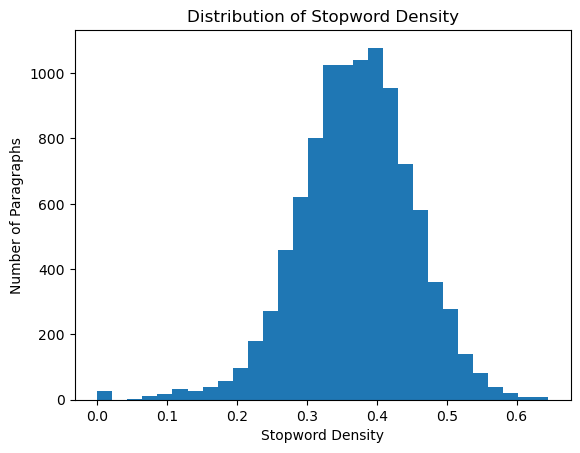

In [397]:
df_exploration = df_cleaned.copy()

def stopword_density(text):
    words = text.split()  # simple split by space
    if len(words) == 0:
        return 0
    num_stopwords = sum(1 for w in words if w.lower() in stop_words)
    return num_stopwords / len(words)

df_exploration["stopword_density"] = df_exploration["text"].astype(str).apply(stopword_density)

print(df_exploration["stopword_density"].describe())

plt.hist(df_exploration["stopword_density"], bins=30)
plt.xlabel("Stopword Density")
plt.ylabel("Number of Paragraphs")
plt.title("Distribution of Stopword Density")
plt.show()


In [398]:
df_exploration.groupby("PCL_category")["stopword_density"].describe()

,count,mean,std,min,25%,50%,75%,max
PCL_category,,,,,,,,
0,8186.0,0.364880,0.082293,0.0,0.314815,0.366667,0.419355,0.645161
1,891.0,0.386052,0.076751,0.0,0.340667,0.388889,0.439024,0.615385
2,138.0,0.373417,0.084980,0.0,0.320000,0.376389,0.424172,0.571429
3,437.0,0.395362,0.075485,0.1,0.343750,0.400000,0.442308,0.583333
4,356.0,0.403547,0.079610,0.1,0.358154,0.410263,0.456391,0.600000


We observe that the most common 20 words are mostly stopwords and the stopword density for texts are approximately normally distributed with mean 0.37 and std 0.08. This may mean that we need more aggressive cleaning. To check that the stopwords don't have a meaningful contribution to the labels, we look at the distribution of stopword density in each PCL category. The observed results are close in each category and doesn't indicate a big risk in cleaning stopwords.

In [399]:
def clean_text_pipeline(text):
    # Decode HTML entities
    text = html.unescape(text)
    # Remove newlines/tabs and collapse spaces
    text = re.sub(r"\s+", " ", text.replace("\n", " ").replace("\t", " ")).strip()
    # Remove special characters (keep only letters/numbers)
    text = re.sub(r"[^\w\s]", "", text)
    # Lowercase & split
    words = text.lower().split()
    tokens = [w for w in words if w not in stop_words]
    return " ".join(tokens)

In [400]:
bigram_counts = Counter()
trigram_counts = Counter()

for text in df_cleaned["text"].astype(str):
    words = clean_text_pipeline(text).split()

    if len(words) < 2:
        continue

    bigram_counts.update(nltk.ngrams(words, 2))
    if len(words) >= 3:
        trigram_counts.update(nltk.ngrams(words, 3))

print("Top 20 Bigrams:")
for bg, count in bigram_counts.most_common(20):
    print(" ".join(bg), count)

print("\nTop 20 Trigrams:")
for tg, count in trigram_counts.most_common(20):
    print(" ".join(tg), count)


Top 20 Bigrams:
poor families 860
illegal immigrants 300
per cent 155
united states 148
homeless people 131
last year 117
people need 111
disabled people 110
hong kong 100
men women 93
donald trump 91
new york 91
sri lanka 88
women children 81
children poor 78
human rights 77
ca nt 72
new zealand 69
migrant workers 68
united nations 63

Top 20 Trigrams:
children poor families 77
president donald trump 53
un refugee agency 37
students poor families 34
many poor families 32
come poor families 31
us president donald 21
h email friend 18
need humanitarian assistance 18
dar es salaam 17
president barack obama 17
high commissioner refugees 16
world war ii 16
working poor families 15
help poor families 15
million people need 14
chancellor angela merkel 13
million poor families 13
papua new guinea 12
refugee agency unhcr 12


Similar to the case of finding the most common words, if stopwords are not removed, especially many common biagrams are purely constructed of stopwords. To avoid this, we apply a text clean pipeline. The n-grams after the cleaning seems to be more meaningful.

In [ ]:
entity_counter = Counter()
for doc in nlp.pipe(df_cleaned["text"].astype(str), batch_size=50):
    entity_counter.update([ent.label_ for ent in doc.ents])

print("Named Entity Recognition (NER):")
for name, count in entity_counter.items():
    print(name, count)


In [ ]:
visible_entity_types = list(entity_counter.keys())

def named_entity_counts(txt: str):
    res = dict.fromkeys(visible_entity_types, 0)
    doc = nlp(txt)
    for ent in doc.ents:
        if ent.label_ in res:
            res[ent.label_] += 1
    return res

In [ ]:
df_extended = df_cleaned.copy()

entity_df = df_extended["text"].astype(str).apply(named_entity_counts).apply(pd.Series)
df_extended = pd.concat([df_extended, entity_df], axis=1)


In [ ]:
df_extended.groupby("is_PCL")[visible_entity_types].mean()

,ORG,GPE,PERSON,NORP,DATE,CARDINAL,WORK_OF_ART,PRODUCT,ORDINAL,TIME,FAC,LOC,LAW,PERCENT,MONEY,QUANTITY,LANGUAGE,EVENT
is_PCL,,,,,,,,,,,,,,,,,,
0,0.619037,0.620690,0.482538,0.279608,0.471742,0.441115,0.021373,0.011568,0.058059,0.028864,0.025669,0.074804,0.008373,0.035034,0.035805,0.014763,0.007491,0.017186
1,0.493018,0.414608,0.483351,0.197637,0.352309,0.259936,0.026853,0.004296,0.042965,0.033298,0.025779,0.060150,0.003222,0.012889,0.023631,0.013963,0.008593,0.013963


In [ ]:
df_extended.groupby("PCL_category")[visible_entity_types].mean()

,ORG,GPE,PERSON,NORP,DATE,CARDINAL,WORK_OF_ART,PRODUCT,ORDINAL,TIME,FAC,LOC,LAW,PERCENT,MONEY,QUANTITY,LANGUAGE,EVENT
PCL_category,,,,,,,,,,,,,,,,,,
0,0.625458,0.634864,0.482409,0.285365,0.479966,0.455778,0.020523,0.012094,0.058759,0.028830,0.025287,0.075739,0.008551,0.037625,0.037014,0.015148,0.007452,0.017347
1,0.560045,0.490460,0.483726,0.226712,0.396184,0.306397,0.029181,0.006734,0.051627,0.029181,0.029181,0.066218,0.006734,0.011223,0.024691,0.011223,0.007856,0.015713
2,0.557971,0.557971,0.565217,0.195652,0.384058,0.347826,0.014493,0.007246,0.057971,0.036232,0.043478,0.094203,0.007246,0.000000,0.014493,0.021739,0.007246,0.021739
3,0.475973,0.384439,0.437071,0.183066,0.382151,0.256293,0.029748,0.004577,0.036613,0.032037,0.018307,0.054920,0.000000,0.016018,0.032037,0.016018,0.013730,0.006865
4,0.488764,0.396067,0.508427,0.216292,0.303371,0.230337,0.028090,0.002809,0.044944,0.033708,0.028090,0.053371,0.005618,0.014045,0.016854,0.008427,0.002809,0.019663


We observe the number of each type of NER in the texts. There seems to be no clear relationship of PCL with:
PERSON, WORK_OF_ART, TIME, QUANTITY,  LANGUAGE, PERCENT, MONEY, EVENT, FAC

Through the differnce between means of the binary (PCL vs no PCL) and (generally) inreasing/decreasing means in categories, counts of the following named entities seem to impact the classification:
ORG, GPE, NORP, DATE, CARDINAL, PRODUCT, ORDINAL, LOC, LAW


In [ ]:
# useful_columns = ["ORG", "GPE", "NORP", "DATE", "CARDINAL", "PRODUCT", "ORDINAL", "LOC", "LAW"]
dropping_columns = ["PERSON", "WORK_OF_ART", "TIME", "QUANTITY",  "LANGUAGE", "PERCENT", "MONEY", "EVENT", "FAC"]
df_extended.drop(columns=dropping_columns, inplace=True)

In [ ]:
df_improved = df_extended.copy()
df_improved["cleaned_text"] = df_improved["text"].astype(str).apply(clean_text_pipeline)
df_improved

,article_id,keyword,country,text,PCL_category,is_PCL,sentence_len,ORG,GPE,NORP,DATE,CARDINAL,PRODUCT,ORDINAL,LOC,LAW,cleaned_text
6,@@9382277,in-need,in,"To bring down high blood sugar levels , insuli...",0,0,75.0,0,0,0,0,0,0,0,0,0,bring high blood sugar levels insulin needs ta...
7,@@7562079,refugee,za,The European Union is making an historic mista...,0,0,50.0,1,1,1,0,0,0,0,0,0,european union making historic mistake haste c...
8,@@23663488,hopeless,nz,""" They 're either hopeless for being beaten by...",0,0,39.0,0,0,0,1,0,0,0,0,0,either hopeless beaten 10yearold beat big bull...
9,@@3449225,homeless,ph,"NUEVA ERA , Ilocos Norte - No family shall be ...",1,0,26.0,0,0,0,0,0,0,0,0,0,nueva era ilocos norte family shall homeless w...
10,@@2485090,in-need,nz,His spokesman said the Kremlin needed more inf...,0,0,54.0,1,2,0,0,0,0,0,0,0,spokesman said kremlin needed information rebe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10464,@@19612634,disabled,ie,When Marie O'Donoghue went looking for a speci...,0,0,38.0,1,0,0,1,0,0,0,0,0,marie odonoghue went looking special school in...
10465,@@14297363,women,lk,Sri Lankan norms and culture inhibit women fro...,1,0,64.0,0,0,0,0,0,0,0,0,0,sri lankan norms culture inhibit women taking ...
10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0,43.0,1,0,0,0,0,0,0,0,0,added afp continue bank application whole nati...
10467,@@20282330,in-need,ng,""" She has one huge platform , and information ...",3,1,58.0,0,1,0,0,1,0,0,0,0,one huge platform information go places really...


To improve further investigation, the texts are cleaned by removing html entities, punctuation, and stopwords.

<Axes: >

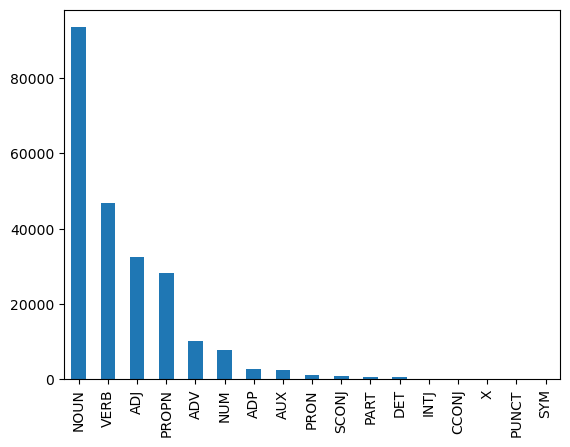

In [ ]:
pos_counter = Counter()
for doc in nlp.pipe(df_improved["cleaned_text"].astype(str), batch_size=50):
    pos_counter.update([token.pos_ for token in doc])

pd.Series(pos_counter).sort_values(ascending=False).plot(kind="bar")


In [ ]:
def verb_noun_ratio(txt: str):
    doc = nlp(txt)
    num_verbs = sum(1 for token in doc if token.pos_ == "VERB")
    num_nouns = sum(1 for token in doc if token.pos_ == "NOUN")
    
    if num_nouns == 0:  # avoid division by zero
        return 0
    return num_verbs / num_nouns

In [ ]:
df_improved["verb_noun_ratio"] = df_improved["cleaned_text"].astype(str).apply(verb_noun_ratio)

In [ ]:
df_improved.groupby("PCL_category")["verb_noun_ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
PCL_category,,,,,,,,
0,8186.0,0.553374,0.331596,0.0,0.357143,0.500000,0.666667,6.000000
1,891.0,0.587611,0.308492,0.0,0.375000,0.500000,0.714286,2.333333
2,138.0,0.644081,0.492146,0.0,0.375000,0.500000,0.813636,4.000000
3,437.0,0.625690,0.406588,0.0,0.380952,0.555556,0.777778,4.000000
4,356.0,0.638227,0.417222,0.0,0.400000,0.545455,0.750000,3.500000


In [ ]:
df_improved.groupby("is_PCL")["verb_noun_ratio"].describe()

,count,mean,std,min,25%,50%,75%,max
is_PCL,,,,,,,,
0,9077.0,0.556735,0.329542,0.0,0.357143,0.500000,0.666667,6.0
1,931.0,0.633210,0.423891,0.0,0.384615,0.545455,0.777778,4.0


We see that there are more nouns than verbs overall. Nevertheless, the PCL texts have overall higher verb noun ratio, which could be a useful feature for our model.

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/opt/homebrew/anaconda3/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


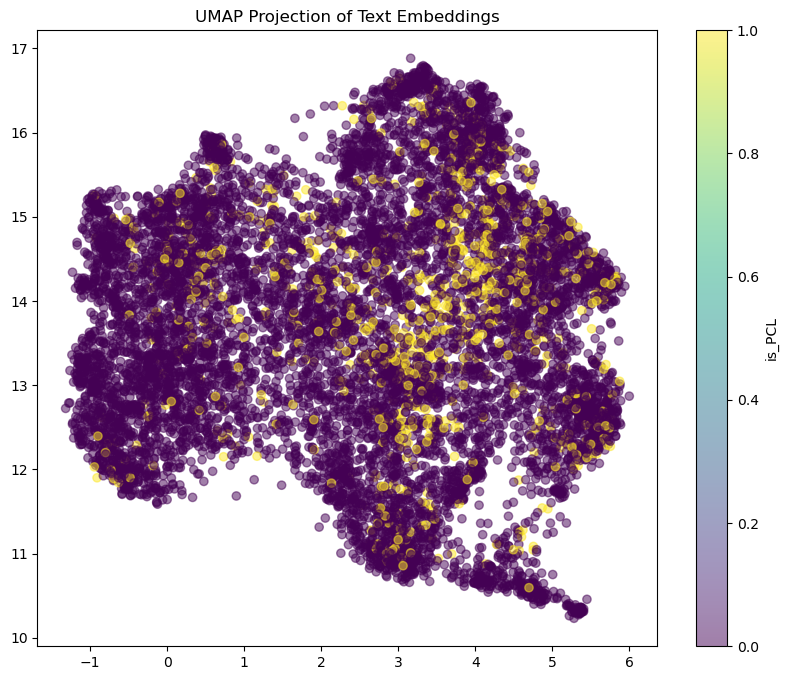

In [ ]:
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt

# Load pre-trained BERT model for sentence embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_improved["text"].astype(str).tolist())

# Reduce to 2D using UMAP
reducer = umap.UMAP(n_neighbors=100, min_dist=0.1, random_state=42)
emb_2d = reducer.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10,8))
plt.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.5, c=df_improved["is_PCL"])
plt.colorbar(label="is_PCL")
plt.title("UMAP Projection of Text Embeddings")
plt.show()


While a clear seperation is not observed in the visualisation, the concentration of PCL examples seems to be at (4, 14.5).

In [ ]:
df_improved["pct_exclam"] = df_improved["text"].str.count("!") / df_improved["sentence_len"] * 100
df_improved["pct_question"] = df_improved["text"].str.count("\?") / df_improved["sentence_len"] * 100
df_improved["pct_quotes"] = df_improved["text"].str.count('"') / df_improved["sentence_len"] * 100

In [ ]:
df_improved.groupby("is_PCL")[["pct_exclam", "pct_question", "pct_quotes"]].describe()

pct_exclam                                                     \
            count      mean       std  min  25%  50%  75%        max   
is_PCL                                                                 
0          9076.0  0.033530  0.483232  0.0  0.0  0.0  0.0  18.750000   
1           931.0  0.056272  0.451998  0.0  0.0  0.0  0.0   7.692308   

       pct_question            ...                 pct_quotes            \
              count      mean  ...  75%        max      count      mean   
is_PCL                         ...                                        
0            9076.0  0.166632  ...  0.0  36.363636     9076.0  1.182156   
1             931.0  0.241330  ...  0.0  18.367347      931.0  1.498510   

                                                      
             std  min  25%  50%       75%        max  
is_PCL                                                
0       2.473151  0.0  0.0  0.0  0.000000  20.000000  
1       2.570575  0.0  0.0  0.0  2.857143  18.181818  

[2 rows x 24 columns]

In [ ]:
df_improved.groupby("PCL_category")[["pct_exclam", "pct_question", "pct_quotes"]].mean()

,pct_exclam,pct_question,pct_quotes
PCL_category,,,
0,0.036190,0.163596,1.136584
1,0.009093,0.194523,1.600799
2,0.023375,0.280500,1.108950
3,0.072749,0.156717,1.586644
4,0.048799,0.330010,1.541331


While we clean the text to get better signals from n-grams and embeddings, we also want to see the effect (simplified) of punctuation. To not have more punctation just because of a longer sentence, we use the ratio punctuation over sentence length and get punctation marks that are used less often and more in (possible) PCL settings.  We observe that the percentage of exlamation points, and question marks are significantly in texts labelled as PCL. However, the use of quotes seem to have no direct contribution with respect to categories.

In [ ]:
df_ready = df_improved.copy()
df_ready.drop(columns = ["pct_quotes", "article_id", "sentence_len", "text"], inplace=True)

To make the data ready for model training, we finally drop article_id,sentence_len, and text columns. While article_id could be helpful to label PCL, our overall goal is to be able to detect PCL in any place, so we don't want our model to get the signals from where the texts are from exactly. In real world, we could have a parameter that evaluates the riskiness of the source. Similarly, as these are just extracts we don't want to overfir on the sentence length. Lastly, since we extracted relevant features from the overall text and formed a clean version that we are going to use for our model, we don't need the initial text anymore.

In [ ]:
df_ready.head()

,keyword,country,PCL_category,is_PCL,ORG,GPE,NORP,DATE,CARDINAL,PRODUCT,ORDINAL,LOC,LAW,cleaned_text,verb_noun_ratio,pct_exclam,pct_question
6,in-need,in,0,0,0,0,0,0,0,0,0,0,0,bring high blood sugar levels insulin needs ta...,0.350000,0.0,0.0
7,refugee,za,0,0,1,1,1,0,0,0,0,0,0,european union making historic mistake haste c...,0.500000,0.0,0.0
8,hopeless,nz,0,0,0,0,0,1,0,0,0,0,0,either hopeless beaten 10yearold beat big bull...,0.750000,0.0,0.0
9,homeless,ph,1,0,0,0,0,0,0,0,0,0,0,nueva era ilocos norte family shall homeless w...,0.500000,0.0,0.0
10,in-need,nz,0,0,1,2,0,0,0,0,0,0,0,spokesman said kremlin needed information rebe...,0.727273,0.0,0.0


In [ ]:
df_ready.columns

Index(['keyword', 'country', 'PCL_category', 'is_PCL', 'ORG', 'GPE', 'NORP',
       'DATE', 'CARDINAL', 'PRODUCT', 'ORDINAL', 'LOC', 'LAW', 'cleaned_text',
       'verb_noun_ratio', 'pct_exclam', 'pct_question'],
      dtype='object')